In [1]:
import numpy as np

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm

import process_data
import config
import network

In [2]:
scan_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/data.nii.gz')
mask_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/nodif_brain_mask.nii.gz')

In [3]:
mask_100206_long_pro = process_data.get_mask_pro(scan_100206, mask_100206)

In [4]:
normalized_scan_100206_full = np.load(config.norm_data_path + '/normalized_scan_100206_full.npy')

In [5]:
bvals_all_100206 = np.loadtxt(config.data_folder2 + '/100206/bvals')

In [54]:
rand_sub_bval_indice_100206 = np.array(process_data.get_rand_selected_bval_indice(bvals_all_100206, 11))

In [55]:
rand_sub_bval_indice_100206

array([ 32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,
        45,  46,  47,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 176, 177, 178, 179, 180, 181, 182, 183,
       184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196,
       197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 224, 225,
       226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238,
       239, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267,
       268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280,
       281, 282, 283, 284, 285, 286, 287])

In [56]:
bvals_100206_sub = bvals_all_100206[rand_sub_bval_indice_100206]*1e-3

In [57]:
normalized_scan_100206_sub = normalized_scan_100206_full[:, rand_sub_bval_indice_100206]

In [58]:
big_b_indice_100206_sub = np.where(bvals_100206_sub != 0.005)[0]

In [59]:
bvals_100206_sub_no_b5 = bvals_100206_sub[big_b_indice_100206_sub]

In [60]:
normalized_scan_100206_sub_no_b5 = normalized_scan_100206_sub[:, big_b_indice_100206_sub]

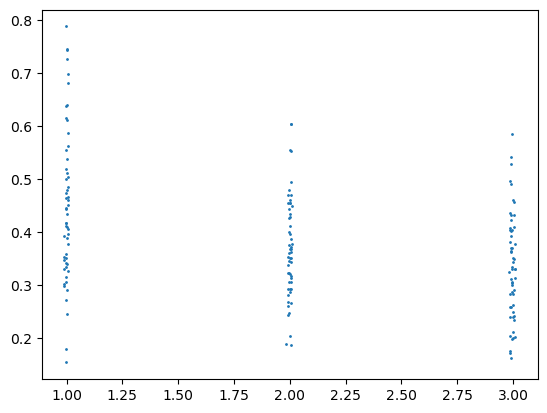

In [61]:
plt.plot(bvals_100206_sub_no_b5, normalized_scan_100206_sub_no_b5[42,:], "o", markersize = 1)

ANN

In [14]:
def squash(param, p_min, p_max):
    squashed_param_tensor =torch.clamp(param, min=p_min, max=p_max)
    unsqueezed_param = squashed_param_tensor.unsqueeze(1)
    return unsqueezed_param

In [50]:
def unitsphere2cart(theta, phi, X):
    mu_cart = torch.zeros(3,X.size()[0])
    sintheta = torch.sin(theta)
    mu_cart[0,:] = torch.squeeze(sintheta * torch.cos(phi))
    mu_cart[1,:] = torch.squeeze(sintheta * torch.sin(phi))
    mu_cart[2,:] = torch.squeeze(torch.cos(theta))
    return mu_cart

In [51]:
class BallStickNet(nn.Module):
    
    def __init__(self, gradient_directions, b_values):
        super(BallStickNet, self).__init__()
        self.gradient_directions = gradient_directions
        self.b_values = b_values
        self.fc_layers = nn.ModuleList()
        for i in range(3): 
            self.fc_layers.extend([nn.Linear(len(b_values), len(b_values)), nn.ELU()])
        self.encoder = nn.Sequential(*self.fc_layers, nn.Linear(len(b_values), 5))
        # if args.dropout != 0:
        #     self.dropout = nn.Dropout(args.dropout)
            
    def forward(self, X):
        # if args.dropout != 0:
        #     X = self.dropout(X)
        params = torch.abs(self.encoder(X))
        theta_uns = params[:, 0]
        theta = theta_uns.unsqueeze(1)
        phi_uns = params[:, 1]
        phi = phi_uns.unsqueeze(1)
        mu_cart = unitsphere2cart(theta, phi, X)
        mm_prod =  torch.einsum("ij,jk->ki",self.gradient_directions, mu_cart)
        lambda_par_uns = params[:, 2]
        lambda_par = squash(lambda_par_uns, 0.1, 3.0)
        lambda_iso_uns = params[:, 3]
        lambda_iso = squash(lambda_iso_uns, 0.1, 3.0)
        volume_0_uns = params[:, 4]
        volume_0 = squash(volume_0_uns, 0.01, 0.99)
        volume_1 = 1-volume_0
        X = volume_0 * torch.exp(-self.b_values * lambda_par * mm_prod ** 2) + volume_1 * torch.exp(-self.b_values * lambda_iso)
        return X, theta, phi, mu_cart, lambda_par, lambda_iso, volume_0, volume_1

In [62]:
n_100206_all = np.loadtxt(config.data_folder2 + '/100206/bvecs')

In [63]:
n_100206_sub = n_100206_all[:, rand_sub_bval_indice_100206]
n_100206_sub_no_b5 = n_100206_sub[:,big_b_indice_100206_sub].T
print(n_100206_sub_no_b5.shape)

b_values_100206_sub_no_b5 = torch.FloatTensor(bvals_100206_sub_no_b5)
gradient_directions_100206_sub_no_b5 = torch.FloatTensor(n_100206_sub_no_b5)

(165, 3)


In [64]:
net = network.BallStickNet(gradient_directions_100206_sub_no_b5, b_values_100206_sub_no_b5)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.00001)

In [65]:
batch_size = 128
num_batches = len(normalized_scan_100206_sub_no_b5) // batch_size
trainloader = utils.DataLoader(torch.from_numpy(normalized_scan_100206_sub_no_b5.astype(np.float32)),
                            batch_size = batch_size, 
                            shuffle = True,
                            num_workers = 2,
                            drop_last = True)

In [66]:
loss_list=[]
avg_loss_list=[]

counter = 0

# Best loss
best = 1e16
num_bad_epochs = 0
patience = 10

for epoch in range(1000):
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    for i, X_batch in enumerate(tqdm(trainloader), 0):
        optimizer.zero_grad()
        X_pred, theta, phi, mu_cart_pred, lambda_par_pred, lambda_iso_pred, volume_0_pred, volume_1_pred = net(X_batch)
        if i == 100 and counter == 10:
            print("X_batch: ")
            print(X_batch.shape)
            print(X_batch)
            print("X_pred: ")
            print(X_pred.shape)
            print(X_pred)
        loss = criterion(X_pred.type(torch.FloatTensor), X_batch.type(torch.FloatTensor))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    loss_list.append(running_loss)
    avg_loss_list.append(running_loss/num_batches)
    print("Loss: {}".format(running_loss))
    print("Average Loss: {}".format(running_loss/num_batches))
    

    if running_loss < best:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best loss: {}".format(best))
            break
    counter += 1

print("Done") 
net.load_state_dict(final_model)

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.04it/s]


Loss: 632.4990976052359
Average Loss: 0.08654886393065625
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 179.69it/s]


Loss: 422.7542085284367
Average Loss: 0.05784814019272533
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:16<00:00, 95.61it/s]


Loss: 420.4453164008446
Average Loss: 0.05753219983591196
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:18<00:00, 93.37it/s]


Loss: 419.2232884778641
Average Loss: 0.0573649820029918
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:16<00:00, 95.51it/s]


Loss: 417.8190417592414
Average Loss: 0.05717283001631655
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 187.36it/s]


Loss: 417.6883808756247
Average Loss: 0.05715495085873354
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 157.81it/s]


Loss: 417.36959545174614
Average Loss: 0.057111329426894654
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:24<00:00, 86.10it/s]


Loss: 416.87621304020286
Average Loss: 0.057043816781636954
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:23<00:00, 87.53it/s]


Loss: 416.2575196395628
Average Loss: 0.0569591570388017
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:16<00:00, 96.04it/s]


Loss: 416.1259721375536
Average Loss: 0.05694115655959957
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 0


  2%|██▍                                                                                                                                                            | 112/7308 [00:04<01:16, 94.01it/s]

X_batch: 
torch.Size([128, 165])
tensor([[0.6970, 0.4623, 0.8920,  ..., 0.4944, 0.4812, 0.7190],
        [0.1418, 0.4285, 0.1900,  ..., 0.4847, 0.2555, 0.1147],
        [0.2461, 0.5297, 0.2660,  ..., 0.5307, 0.4163, 0.1859],
        ...,
        [0.3597, 0.3262, 0.5009,  ..., 0.4499, 0.3093, 0.4496],
        [0.1253, 0.1232, 0.1133,  ..., 0.2172, 0.1721, 0.1397],
        [0.1716, 0.4293, 0.2501,  ..., 0.4065, 0.2560, 0.1832]])
X_pred: 
torch.Size([128, 165])
tensor([[0.5851, 0.7234, 0.6681,  ..., 0.6718, 0.6476, 0.5444],
        [0.1523, 0.4647, 0.2496,  ..., 0.4534, 0.2491, 0.1468],
        [0.2638, 0.4556, 0.3261,  ..., 0.4313, 0.3210, 0.2474],
        ...,
        [0.2399, 0.4746, 0.3139,  ..., 0.4548, 0.3137, 0.2285],
        [0.1022, 0.1926, 0.1217,  ..., 0.1819, 0.1199, 0.0957],
        [0.1918, 0.4865, 0.2860,  ..., 0.4713, 0.2811, 0.1820]],
       grad_fn=<AddBackward0>)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.89it/s]


Loss: 415.1990566093009
Average Loss: 0.05681432082776422
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.68it/s]


Loss: 415.48141363984905
Average Loss: 0.056852957531451705
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.75it/s]


Loss: 414.77801791136153
Average Loss: 0.05675670743176813
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 194.07it/s]


Loss: 414.75470582116395
Average Loss: 0.056753517490580725
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 186.95it/s]


Loss: 414.5217001272831
Average Loss: 0.056721633843361124
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.77it/s]


Loss: 414.4039134699851
Average Loss: 0.05670551634783595
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 181.59it/s]


Loss: 414.396437860094
Average Loss: 0.056704493412711277
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.19it/s]


Loss: 414.30737194698304
Average Loss: 0.05669230595880994
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.55it/s]


Loss: 413.7007803693414
Average Loss: 0.05660930218518628
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 210.19it/s]


Loss: 413.8668446303345
Average Loss: 0.05663202581148529
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.64it/s]


Loss: 412.97110747452825
Average Loss: 0.05650945641413906
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.78it/s]


Loss: 413.5833144863136
Average Loss: 0.05659322858323941
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.26it/s]


Loss: 412.9276786954142
Average Loss: 0.056503513778792314
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.69it/s]


Loss: 412.81735217012465
Average Loss: 0.056488417100454935
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.50it/s]


Loss: 412.74750304664485
Average Loss: 0.05647885920178501
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 206.44it/s]


Loss: 412.6170525138732
Average Loss: 0.05646100882784253
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.01it/s]


Loss: 412.1333284676075
Average Loss: 0.056394817797975845
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.83it/s]


Loss: 412.31282924464904
Average Loss: 0.056419380028003424
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.40it/s]


Loss: 411.94439767929725
Average Loss: 0.0563689651996849
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 230.46it/s]


Loss: 412.14094237214886
Average Loss: 0.05639585965683482
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 197.81it/s]


Loss: 411.46713743917644
Average Loss: 0.05630365865341769
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 210.59it/s]


Loss: 411.94952195952646
Average Loss: 0.056369666387455726
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.51it/s]


Loss: 411.37343220063485
Average Loss: 0.056290836371187036
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.67it/s]


Loss: 411.625069628004
Average Loss: 0.05632526951669458
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.24it/s]


Loss: 411.34446218283847
Average Loss: 0.0562868722198739
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.10it/s]


Loss: 411.4805078045465
Average Loss: 0.056305488205329296
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 207.55it/s]


Loss: 410.9265379635617
Average Loss: 0.05622968499775065
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.91it/s]


Loss: 411.37239349470474
Average Loss: 0.05629069423846535
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.54it/s]


Loss: 411.04432522691786
Average Loss: 0.0562458025762066
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.03it/s]


Loss: 411.1085349456407
Average Loss: 0.056254588799348755
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 210.56it/s]


Loss: 410.5909325827379
Average Loss: 0.056183761984501625
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.36it/s]


Loss: 410.7378911122214
Average Loss: 0.05620387125235651
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 189.83it/s]


Loss: 410.729443048127
Average Loss: 0.05620271525015422
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 168.96it/s]


Loss: 410.60178877739236
Average Loss: 0.056185247506484993
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 186.30it/s]


Loss: 410.532296059886
Average Loss: 0.056175738377105364
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.94it/s]


Loss: 410.4400247305166
Average Loss: 0.05616311230576308
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 202.52it/s]


Loss: 410.448242734652
Average Loss: 0.05616423682740175
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.79it/s]


Loss: 410.4401675516274
Average Loss: 0.05616313184888169
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.31it/s]


Loss: 410.4456698319409
Average Loss: 0.05616388476080199
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 203.86it/s]


Loss: 410.4924438293092
Average Loss: 0.05617028514358363
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.15it/s]


Loss: 410.2191579057835
Average Loss: 0.05613288969701471
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 194.72it/s]


Loss: 410.32940972968936
Average Loss: 0.05614797615348787
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.09it/s]


Loss: 410.18087018467486
Average Loss: 0.05612765054524834
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 192.76it/s]


Loss: 410.26344735827297
Average Loss: 0.0561389501037593
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.91it/s]


Loss: 410.09472381090745
Average Loss: 0.05611586259043616
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.17it/s]


Loss: 409.21812828071415
Average Loss: 0.05599591246315191
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 206.33it/s]


Loss: 407.2919773031026
Average Loss: 0.05573234500589801
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 223.52it/s]


Loss: 406.7613200535998
Average Loss: 0.05565973180810068
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 206.04it/s]


Loss: 406.3500527187716
Average Loss: 0.05560345548970602
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.78it/s]


Loss: 405.81774258054793
Average Loss: 0.05553061611665954
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.74it/s]


Loss: 405.57353126769885
Average Loss: 0.05549719913351106
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 208.42it/s]


Loss: 405.1482075676322
Average Loss: 0.05543899939349099
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 62; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.40it/s]


Loss: 404.9458456414286
Average Loss: 0.05541130892739855
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 63; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 207.10it/s]


Loss: 404.53449389874004
Average Loss: 0.05535502105894089
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 64; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.36it/s]


Loss: 403.964825873496
Average Loss: 0.05527706976922496
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 65; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 208.48it/s]


Loss: 403.99329016776755
Average Loss: 0.055280964719180016
-----------------------------------------------------------------
Epoch: 66; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 238.60it/s]


Loss: 403.7617274604272
Average Loss: 0.05524927852496267
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 67; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.01it/s]


Loss: 403.42389334132895
Average Loss: 0.055203050539317046
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 68; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.69it/s]


Loss: 402.99328839522786
Average Loss: 0.05514412813289927
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 69; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.45it/s]


Loss: 402.8696561672259
Average Loss: 0.05512721075085193
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 70; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.09it/s]


Loss: 402.88734630751424
Average Loss: 0.055129631404969105
-----------------------------------------------------------------
Epoch: 71; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.30it/s]


Loss: 402.3042557002045
Average Loss: 0.05504984341819985
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 72; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.00it/s]


Loss: 402.0535286271479
Average Loss: 0.055015534842247936
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 73; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 226.65it/s]


Loss: 402.1525857867673
Average Loss: 0.05502908946179082
-----------------------------------------------------------------
Epoch: 74; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 225.18it/s]


Loss: 401.9743762360886
Average Loss: 0.05500470391845766
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 75; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.35it/s]


Loss: 401.9533629748039
Average Loss: 0.055001828540613557
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 76; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.88it/s]


Loss: 401.8557663601823
Average Loss: 0.054988473776708034
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 77; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.78it/s]


Loss: 401.52967342734337
Average Loss: 0.05494385241206121
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 78; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.43it/s]


Loss: 401.5635453653522
Average Loss: 0.05494848732421349
-----------------------------------------------------------------
Epoch: 79; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.28it/s]


Loss: 401.2738129494246
Average Loss: 0.05490884139975706
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 80; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 225.99it/s]


Loss: 401.14349409844726
Average Loss: 0.05489100904466985
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 81; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.08it/s]


Loss: 401.03703696397133
Average Loss: 0.05487644183962388
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 82; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 207.08it/s]


Loss: 400.9617636371404
Average Loss: 0.05486614171279972
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 83; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 226.15it/s]


Loss: 400.72037235600874
Average Loss: 0.05483311061248067
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 84; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.92it/s]


Loss: 400.81261272355914
Average Loss: 0.05484573244712085
-----------------------------------------------------------------
Epoch: 85; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.75it/s]


Loss: 400.8409630630631
Average Loss: 0.05484961180392215
-----------------------------------------------------------------
Epoch: 86; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 221.13it/s]


Loss: 400.61421111016534
Average Loss: 0.05481858389575333
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 87; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 206.92it/s]


Loss: 400.49366108630784
Average Loss: 0.054802088271251756
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 88; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 206.13it/s]


Loss: 400.57637194590643
Average Loss: 0.05481340612286623
-----------------------------------------------------------------
Epoch: 89; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.91it/s]


Loss: 400.4278784112539
Average Loss: 0.05479308681051641
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 90; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.73it/s]


Loss: 400.2288254450541
Average Loss: 0.054765849130412436
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 91; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.52it/s]


Loss: 400.28149025607854
Average Loss: 0.054773055590596406
-----------------------------------------------------------------
Epoch: 92; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.48it/s]


Loss: 400.3195898628328
Average Loss: 0.05477826900148232
-----------------------------------------------------------------
Epoch: 93; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 185.47it/s]


Loss: 400.1847097899299
Average Loss: 0.05475981250546386
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 94; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 171.37it/s]


Loss: 400.116088000359
Average Loss: 0.05475042255067857
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 95; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.10it/s]


Loss: 400.12918040389195
Average Loss: 0.054752214067308694
-----------------------------------------------------------------
Epoch: 96; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 183.28it/s]


Loss: 399.9085029675625
Average Loss: 0.05472201737377703
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 97; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 205.85it/s]


Loss: 399.85625763540156
Average Loss: 0.054714868313547015
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 98; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 143.90it/s]


Loss: 399.86216634791344
Average Loss: 0.054715676840163305
-----------------------------------------------------------------
Epoch: 99; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:04<00:00, 112.58it/s]


Loss: 399.75076002115384
Average Loss: 0.05470043240574081
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 100; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:58<00:00, 125.05it/s]


Loss: 399.8212125012651
Average Loss: 0.05471007286552615
-----------------------------------------------------------------
Epoch: 101; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:27<00:00, 83.20it/s]


Loss: 399.6814456982538
Average Loss: 0.05469094768722685
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 102; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:58<00:00, 124.03it/s]


Loss: 399.58099379506893
Average Loss: 0.05467720221607402
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 103; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:57<00:00, 126.75it/s]


Loss: 399.6247252712492
Average Loss: 0.054683186271380566
-----------------------------------------------------------------
Epoch: 104; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 135.59it/s]


Loss: 399.57600616733544
Average Loss: 0.05467651972733107
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 105; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 154.51it/s]


Loss: 399.6195914724376
Average Loss: 0.054682483781121734
-----------------------------------------------------------------
Epoch: 106; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 136.96it/s]


Loss: 399.5338691454381
Average Loss: 0.05467075385131884
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 107; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 141.18it/s]


Loss: 399.46172104170546
Average Loss: 0.05466088136859681
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 108; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 135.25it/s]


Loss: 399.30263564246707
Average Loss: 0.05463911270422374
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 109; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 134.08it/s]


Loss: 399.407990941545
Average Loss: 0.05465352913814245
-----------------------------------------------------------------
Epoch: 110; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 142.58it/s]


Loss: 399.41110976040363
Average Loss: 0.05465395590591183
-----------------------------------------------------------------
Epoch: 111; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 143.09it/s]


Loss: 399.40576291573234
Average Loss: 0.0546532242632365
-----------------------------------------------------------------
Epoch: 112; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 142.52it/s]


Loss: 399.32901686243713
Average Loss: 0.05464272261390765
-----------------------------------------------------------------
Epoch: 113; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 154.78it/s]


Loss: 399.2489761565812
Average Loss: 0.054631770136368524
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 114; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 145.83it/s]


Loss: 399.2469045280013
Average Loss: 0.054631486662288085
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 115; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:29<00:00, 81.95it/s]


Loss: 399.15032658493146
Average Loss: 0.05461827128967316
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 116; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 170.19it/s]


Loss: 399.0312880638521
Average Loss: 0.054601982493685294
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 117; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 187.39it/s]


Loss: 399.1594378326554
Average Loss: 0.05461951803949855
-----------------------------------------------------------------
Epoch: 118; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.11it/s]


Loss: 399.0725620915182
Average Loss: 0.05460763028072225
-----------------------------------------------------------------
Epoch: 119; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.14it/s]


Loss: 399.2196457639802
Average Loss: 0.05462775667268476
-----------------------------------------------------------------
Epoch: 120; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 173.42it/s]


Loss: 398.97328507434577
Average Loss: 0.054594045576675666
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 121; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.19it/s]


Loss: 399.06279616546817
Average Loss: 0.0546062939471084
-----------------------------------------------------------------
Epoch: 122; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.55it/s]


Loss: 398.96488081128336
Average Loss: 0.05459289556804644
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 123; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.15it/s]


Loss: 398.91396379470825
Average Loss: 0.05458592826966451
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 124; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 206.23it/s]


Loss: 399.0810127535369
Average Loss: 0.054608786638415015
-----------------------------------------------------------------
Epoch: 125; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 176.08it/s]


Loss: 398.87558603147045
Average Loss: 0.054580676796862404
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 126; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 171.37it/s]


Loss: 398.8817151149269
Average Loss: 0.05458151547823302
-----------------------------------------------------------------
Epoch: 127; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.88it/s]


Loss: 398.799926918
Average Loss: 0.05457032388040503
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 128; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 185.93it/s]


Loss: 398.79911718005314
Average Loss: 0.05457021307882501
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 129; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.09it/s]


Loss: 398.97355137509294
Average Loss: 0.054594082016296244
-----------------------------------------------------------------
Epoch: 130; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.62it/s]


Loss: 398.77061029477045
Average Loss: 0.05456631230087171
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 131; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.37it/s]


Loss: 398.79969526431523
Average Loss: 0.0545702921817618
-----------------------------------------------------------------
Epoch: 132; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.77it/s]


Loss: 398.66584367421456
Average Loss: 0.05455197641956959
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 133; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 129.13it/s]


Loss: 398.663318538107
Average Loss: 0.0545516308891772
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 134; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:02<00:00, 116.55it/s]


Loss: 398.60800722870044
Average Loss: 0.05454406229183093
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 135; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 179.79it/s]


Loss: 398.61925843171775
Average Loss: 0.054545601865314416
-----------------------------------------------------------------
Epoch: 136; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 194.83it/s]


Loss: 398.79532824014314
Average Loss: 0.054569694614141094
-----------------------------------------------------------------
Epoch: 137; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.37it/s]


Loss: 398.5893419452477
Average Loss: 0.05454150820268852
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 138; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 185.15it/s]


Loss: 398.6522804375272
Average Loss: 0.05455012047585211
-----------------------------------------------------------------
Epoch: 139; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 135.76it/s]


Loss: 398.68008812493645
Average Loss: 0.05455392557812486
-----------------------------------------------------------------
Epoch: 140; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 143.66it/s]


Loss: 398.503080671886
Average Loss: 0.05452970452543596
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 141; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 139.62it/s]


Loss: 398.6079753364902
Average Loss: 0.05454405792781749
-----------------------------------------------------------------
Epoch: 142; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:11<00:00, 102.75it/s]


Loss: 398.48337965039536
Average Loss: 0.05452700870968738
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 143; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 189.80it/s]


Loss: 398.57095286552794
Average Loss: 0.054538991908255056
-----------------------------------------------------------------
Epoch: 144; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 144.35it/s]


Loss: 398.4418880501762
Average Loss: 0.05452133115081776
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 145; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 133.95it/s]


Loss: 398.46148063754663
Average Loss: 0.0545240121288378
-----------------------------------------------------------------
Epoch: 146; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:06<00:00, 110.32it/s]


Loss: 398.43776606046595
Average Loss: 0.054520767112816906
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 147; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 202.55it/s]


Loss: 398.50054769869894
Average Loss: 0.05452935792264627
-----------------------------------------------------------------
Epoch: 148; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 161.21it/s]


Loss: 398.3844410558231
Average Loss: 0.05451347031415204
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 149; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:58<00:00, 124.83it/s]


Loss: 398.4594394976739
Average Loss: 0.054523732826720565
-----------------------------------------------------------------
Epoch: 150; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 133.95it/s]


Loss: 398.36073351395316
Average Loss: 0.054510226260803665
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 151; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 136.61it/s]


Loss: 398.39812782010995
Average Loss: 0.054515343160934586
-----------------------------------------------------------------
Epoch: 152; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 128.68it/s]


Loss: 398.39484379882924
Average Loss: 0.05451489378746979
-----------------------------------------------------------------
Epoch: 153; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 129.82it/s]


Loss: 398.36632296442986
Average Loss: 0.054510991100770366
-----------------------------------------------------------------
Epoch: 154; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 147.31it/s]


Loss: 398.3081487249583
Average Loss: 0.05450303075054164
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 155; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 133.93it/s]


Loss: 398.35833785054274
Average Loss: 0.054509898446981765
-----------------------------------------------------------------
Epoch: 156; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 128.52it/s]


Loss: 398.37427955609746
Average Loss: 0.05451207985168274
-----------------------------------------------------------------
Epoch: 157; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 142.60it/s]


Loss: 398.30538076884113
Average Loss: 0.05450265199354695
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 158; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 179.60it/s]


Loss: 398.32818351103924
Average Loss: 0.05450577223741643
-----------------------------------------------------------------
Epoch: 159; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 144.93it/s]


Loss: 398.1888673454523
Average Loss: 0.05448670872269462
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 160; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:01<00:00, 119.23it/s]


Loss: 398.18181306286715
Average Loss: 0.054485743440458013
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 161; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 173.98it/s]


Loss: 398.3841848964803
Average Loss: 0.054513435262244156
-----------------------------------------------------------------
Epoch: 162; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 185.10it/s]


Loss: 398.19031241559424
Average Loss: 0.05448690646080928
-----------------------------------------------------------------
Epoch: 163; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.40it/s]


Loss: 398.3179555584211
Average Loss: 0.054504372681776284
-----------------------------------------------------------------
Epoch: 164; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 184.14it/s]


Loss: 398.2179678520188
Average Loss: 0.054490690729613954
-----------------------------------------------------------------
Epoch: 165; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 184.12it/s]


Loss: 398.29336937330663
Average Loss: 0.054501008398098884
-----------------------------------------------------------------
Epoch: 166; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 189.61it/s]


Loss: 398.0970637113787
Average Loss: 0.0544741466490666
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 167; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 140.95it/s]


Loss: 398.16578964865766
Average Loss: 0.054483550855043465
-----------------------------------------------------------------
Epoch: 168; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 176.19it/s]


Loss: 398.1565330612939
Average Loss: 0.05448228421747316
-----------------------------------------------------------------
Epoch: 169; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.52it/s]


Loss: 398.29627936705947
Average Loss: 0.0545014065910043
-----------------------------------------------------------------
Epoch: 170; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 161.44it/s]


Loss: 398.2255982537754
Average Loss: 0.054491734845891544
-----------------------------------------------------------------
Epoch: 171; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:04<00:00, 112.82it/s]


Loss: 398.22642299858853
Average Loss: 0.05449184770095628
-----------------------------------------------------------------
Epoch: 172; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 168.32it/s]


Loss: 398.1742222090252
Average Loss: 0.054484704735772466
-----------------------------------------------------------------
Epoch: 173; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 146.43it/s]


Loss: 398.0542005172465
Average Loss: 0.054468281406300834
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 174; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 145.49it/s]


Loss: 398.1976484514307
Average Loss: 0.05448791029713064
-----------------------------------------------------------------
Epoch: 175; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 156.15it/s]


Loss: 398.0544418368954
Average Loss: 0.054468314427599265
-----------------------------------------------------------------
Epoch: 176; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 155.87it/s]


Loss: 398.1240124842152
Average Loss: 0.05447783422060963
-----------------------------------------------------------------
Epoch: 177; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 163.48it/s]


Loss: 398.0915830859449
Average Loss: 0.054473396700320864
-----------------------------------------------------------------
Epoch: 178; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 165.08it/s]


Loss: 398.21536367200315
Average Loss: 0.05449033438314219
-----------------------------------------------------------------
Epoch: 179; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 166.23it/s]


Loss: 397.9596400524024
Average Loss: 0.05445534209802989
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 180; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 174.10it/s]


Loss: 398.0014442722313
Average Loss: 0.054461062434623876
-----------------------------------------------------------------
Epoch: 181; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 168.15it/s]


Loss: 398.07419514725916
Average Loss: 0.05447101739836606
-----------------------------------------------------------------
Epoch: 182; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 150.25it/s]


Loss: 398.15950329438783
Average Loss: 0.054482690653309775
-----------------------------------------------------------------
Epoch: 183; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.68it/s]


Loss: 397.9760210355744
Average Loss: 0.05445758361187389
-----------------------------------------------------------------
Epoch: 184; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 161.31it/s]


Loss: 397.9772464334965
Average Loss: 0.054457751290845166
-----------------------------------------------------------------
Epoch: 185; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 166.90it/s]


Loss: 397.95699634728953
Average Loss: 0.054454980343088336
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 186; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 160.28it/s]


Loss: 397.98743448476307
Average Loss: 0.05445914538653025
-----------------------------------------------------------------
Epoch: 187; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 162.18it/s]


Loss: 398.0694186280016
Average Loss: 0.05447036379693508
-----------------------------------------------------------------
Epoch: 188; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 159.57it/s]


Loss: 398.0150509227533
Average Loss: 0.05446292431893176
-----------------------------------------------------------------
Epoch: 189; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 165.15it/s]


Loss: 398.00654148100875
Average Loss: 0.05446175991803623
-----------------------------------------------------------------
Epoch: 190; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 159.63it/s]


Loss: 398.03251277678646
Average Loss: 0.05446531373519246
-----------------------------------------------------------------
Epoch: 191; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 166.64it/s]


Loss: 397.9858873768244
Average Loss: 0.05445893368593656
-----------------------------------------------------------------
Epoch: 192; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 160.42it/s]


Loss: 397.9044425988104
Average Loss: 0.054447789080296995
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 193; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 165.85it/s]


Loss: 397.8907467091922
Average Loss: 0.05444591498483746
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 194; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 159.61it/s]


Loss: 397.8803811513353
Average Loss: 0.05444449659979958
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 195; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 161.61it/s]


Loss: 397.8673186637461
Average Loss: 0.054442709176757816
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 196; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 162.16it/s]


Loss: 397.957878976129
Average Loss: 0.0544551011187916
-----------------------------------------------------------------
Epoch: 197; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 163.85it/s]


Loss: 397.8637267432641
Average Loss: 0.05444221767149208
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 198; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 161.04it/s]


Loss: 397.89562063338235
Average Loss: 0.054446581914803276
-----------------------------------------------------------------
Epoch: 199; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 165.29it/s]


Loss: 397.88223289488815
Average Loss: 0.05444474998561688
-----------------------------------------------------------------
Epoch: 200; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.85it/s]


Loss: 397.8596555155236
Average Loss: 0.054441660579573566
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 201; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 159.93it/s]


Loss: 397.8400393463671
Average Loss: 0.054438976374708146
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 202; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.25it/s]


Loss: 397.79993708012626
Average Loss: 0.054433488927220344
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 203; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.43it/s]


Loss: 397.90270841354504
Average Loss: 0.054447551780725925
-----------------------------------------------------------------
Epoch: 204; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.33it/s]


Loss: 397.8187422428746
Average Loss: 0.054436062156934126
-----------------------------------------------------------------
Epoch: 205; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 163.03it/s]


Loss: 397.8584192211274
Average Loss: 0.05444149140956861
-----------------------------------------------------------------
Epoch: 206; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 161.07it/s]


Loss: 397.86864209733903
Average Loss: 0.05444289027057184
-----------------------------------------------------------------
Epoch: 207; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 162.20it/s]


Loss: 397.83836416434497
Average Loss: 0.054438747148925146
-----------------------------------------------------------------
Epoch: 208; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 162.04it/s]


Loss: 397.7320775887929
Average Loss: 0.05442420328253871
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 209; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 163.40it/s]


Loss: 397.74936921033077
Average Loss: 0.05442656940480717
-----------------------------------------------------------------
Epoch: 210; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 162.86it/s]


Loss: 397.7354809716344
Average Loss: 0.05442466898900306
-----------------------------------------------------------------
Epoch: 211; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 162.35it/s]


Loss: 397.73931251862086
Average Loss: 0.05442519328388353
-----------------------------------------------------------------
Epoch: 212; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 163.36it/s]


Loss: 397.80113327968866
Average Loss: 0.05443365261079484
-----------------------------------------------------------------
Epoch: 213; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 161.64it/s]


Loss: 397.78521838691086
Average Loss: 0.05443147487505622
-----------------------------------------------------------------
Epoch: 214; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 163.53it/s]


Loss: 397.6756492962595
Average Loss: 0.054416481841305354
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 215; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:58<00:00, 125.21it/s]


Loss: 397.73082214430906
Average Loss: 0.054424031492105784
-----------------------------------------------------------------
Epoch: 216; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:55<00:00, 130.95it/s]


Loss: 397.7278749134857
Average Loss: 0.05442362820381578
-----------------------------------------------------------------
Epoch: 217; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 171.93it/s]


Loss: 397.7866234059911
Average Loss: 0.05443166713273004
-----------------------------------------------------------------
Epoch: 218; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 149.25it/s]


Loss: 397.8830038988963
Average Loss: 0.054444855486986354
-----------------------------------------------------------------
Epoch: 219; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 159.12it/s]


Loss: 397.65020772838034
Average Loss: 0.05441300051017793
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 220; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 161.89it/s]


Loss: 397.68528687697835
Average Loss: 0.05441780061261335
-----------------------------------------------------------------
Epoch: 221; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 138.06it/s]


Loss: 397.6777187718544
Average Loss: 0.054416765020779204
-----------------------------------------------------------------
Epoch: 222; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 157.74it/s]


Loss: 397.70136982784607
Average Loss: 0.05442000134480652
-----------------------------------------------------------------
Epoch: 223; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 165.28it/s]


Loss: 397.73018921003677
Average Loss: 0.05442394488369414
-----------------------------------------------------------------
Epoch: 224; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 143.37it/s]


Loss: 397.71579773235135
Average Loss: 0.05442197560650675
-----------------------------------------------------------------
Epoch: 225; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 167.56it/s]


Loss: 397.61064470699057
Average Loss: 0.05440758685098393
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 226; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:05<00:00, 111.08it/s]


Loss: 397.581871897215
Average Loss: 0.054403649684895326
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 227; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:55<00:00, 131.93it/s]


Loss: 397.5833050454967
Average Loss: 0.05440384579166621
-----------------------------------------------------------------
Epoch: 228; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 150.92it/s]


Loss: 397.6311794568319
Average Loss: 0.054410396751071684
-----------------------------------------------------------------
Epoch: 229; Bad epochs: 2


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:14<00:00, 98.58it/s]


Loss: 397.6386962092947
Average Loss: 0.054411425315995444
-----------------------------------------------------------------
Epoch: 230; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:07<00:00, 108.83it/s]


Loss: 397.6068618816789
Average Loss: 0.05440706922299931
-----------------------------------------------------------------
Epoch: 231; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 154.90it/s]


Loss: 397.5482077570632
Average Loss: 0.05439904320704204
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 232; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.40it/s]


Loss: 397.61986275110394
Average Loss: 0.05440884821443677
-----------------------------------------------------------------
Epoch: 233; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.93it/s]


Loss: 397.628844630206
Average Loss: 0.05441007726193295
-----------------------------------------------------------------
Epoch: 234; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.61it/s]


Loss: 397.60389617993496
Average Loss: 0.05440666340721606
-----------------------------------------------------------------
Epoch: 235; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.14it/s]


Loss: 397.56410381454043
Average Loss: 0.05440121836542699
-----------------------------------------------------------------
Epoch: 236; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.02it/s]


Loss: 397.590734468773
Average Loss: 0.05440486240678339
-----------------------------------------------------------------
Epoch: 237; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.03it/s]


Loss: 397.56923400913365
Average Loss: 0.05440192036249776
-----------------------------------------------------------------
Epoch: 238; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 197.21it/s]


Loss: 397.64324388536625
Average Loss: 0.05441204760336155
-----------------------------------------------------------------
Epoch: 239; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.05it/s]


Loss: 397.5683210042771
Average Loss: 0.05440179543025138
-----------------------------------------------------------------
Epoch: 240; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 145.50it/s]


Loss: 397.56468589720316
Average Loss: 0.054401298015490304
-----------------------------------------------------------------
Epoch: 241; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 167.99it/s]


Loss: 397.5019911949057
Average Loss: 0.0543927191016565
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 242; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 138.32it/s]


Loss: 397.53516322094947
Average Loss: 0.05439725824041454
-----------------------------------------------------------------
Epoch: 243; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 153.49it/s]


Loss: 397.5809361594729
Average Loss: 0.054403521641964
-----------------------------------------------------------------
Epoch: 244; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.21it/s]


Loss: 397.56603538780473
Average Loss: 0.05440148267485013
-----------------------------------------------------------------
Epoch: 245; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 221.23it/s]


Loss: 397.5386258389335
Average Loss: 0.05439773205239922
-----------------------------------------------------------------
Epoch: 246; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.32it/s]


Loss: 397.52825302258134
Average Loss: 0.054396312674135375
-----------------------------------------------------------------
Epoch: 247; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 205.08it/s]


Loss: 397.57660551625304
Average Loss: 0.05440292905257978
-----------------------------------------------------------------
Epoch: 248; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:10<00:00, 104.17it/s]


Loss: 397.5826183608733
Average Loss: 0.05440375182825305
-----------------------------------------------------------------
Epoch: 249; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 137.63it/s]


Loss: 397.6398900016211
Average Loss: 0.05441158867017257
-----------------------------------------------------------------
Epoch: 250; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 142.20it/s]


Loss: 397.45374703384005
Average Loss: 0.05438611754704981
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 251; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 129.18it/s]


Loss: 397.52982636983506
Average Loss: 0.054396527965221
-----------------------------------------------------------------
Epoch: 252; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.68it/s]


Loss: 397.54617253807373
Average Loss: 0.05439876471511682
-----------------------------------------------------------------
Epoch: 253; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.50it/s]


Loss: 397.4523131616879
Average Loss: 0.05438592134122714
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 254; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.30it/s]


Loss: 397.4940407781396
Average Loss: 0.054391631195695074
-----------------------------------------------------------------
Epoch: 255; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.15it/s]


Loss: 397.4595695002936
Average Loss: 0.054386914272070826
-----------------------------------------------------------------
Epoch: 256; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 207.81it/s]


Loss: 397.4934854290914
Average Loss: 0.05439155520376182
-----------------------------------------------------------------
Epoch: 257; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 210.41it/s]


Loss: 397.43172484682873
Average Loss: 0.05438310411149819
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 258; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.77it/s]


Loss: 397.44522313936614
Average Loss: 0.05438495116849564
-----------------------------------------------------------------
Epoch: 259; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 203.17it/s]


Loss: 397.45897014043294
Average Loss: 0.05438683225785891
-----------------------------------------------------------------
Epoch: 260; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.89it/s]


Loss: 397.4974826502148
Average Loss: 0.05439210216888544
-----------------------------------------------------------------
Epoch: 261; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.97it/s]


Loss: 397.51651957747526
Average Loss: 0.054394707112407674
-----------------------------------------------------------------
Epoch: 262; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.46it/s]


Loss: 397.4692301659379
Average Loss: 0.054388236202235624
-----------------------------------------------------------------
Epoch: 263; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.50it/s]


Loss: 397.41086085001007
Average Loss: 0.05438024915845786
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 264; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 210.05it/s]


Loss: 397.4592153192498
Average Loss: 0.05438686580723177
-----------------------------------------------------------------
Epoch: 265; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.87it/s]


Loss: 397.4482915799599
Average Loss: 0.05438537104268745
-----------------------------------------------------------------
Epoch: 266; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.30it/s]


Loss: 397.4499836114701
Average Loss: 0.054385602574092785
-----------------------------------------------------------------
Epoch: 267; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 223.93it/s]


Loss: 397.3864375418052
Average Loss: 0.05437690716226125
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 268; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 207.10it/s]


Loss: 397.38588202930987
Average Loss: 0.05437683114796249
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 269; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.25it/s]


Loss: 397.4487888868898
Average Loss: 0.054385439092349455
-----------------------------------------------------------------
Epoch: 270; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.52it/s]


Loss: 397.38469751900993
Average Loss: 0.05437666906390393
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 271; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 224.42it/s]


Loss: 397.37479012995027
Average Loss: 0.05437531337300907
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 272; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.35it/s]


Loss: 397.3742821533233
Average Loss: 0.05437524386334473
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 273; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 223.17it/s]


Loss: 397.37191211036406
Average Loss: 0.0543749195553317
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 274; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.65it/s]


Loss: 397.4050417114049
Average Loss: 0.05437945288880746
-----------------------------------------------------------------
Epoch: 275; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 222.65it/s]


Loss: 397.45617560087703
Average Loss: 0.05438644986328366
-----------------------------------------------------------------
Epoch: 276; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 221.25it/s]


Loss: 397.4615629715845
Average Loss: 0.05438718705139361
-----------------------------------------------------------------
Epoch: 277; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.39it/s]


Loss: 397.55040695657954
Average Loss: 0.05439934413746299
-----------------------------------------------------------------
Epoch: 278; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 222.95it/s]


Loss: 397.41890710406005
Average Loss: 0.05438135017844281
-----------------------------------------------------------------
Epoch: 279; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.91it/s]


Loss: 397.472874928033
Average Loss: 0.054388734938154486
-----------------------------------------------------------------
Epoch: 280; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.24it/s]


Loss: 397.4419366661459
Average Loss: 0.05438450145951641
-----------------------------------------------------------------
Epoch: 281; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.09it/s]


Loss: 397.42097350768745
Average Loss: 0.05438163293755986
-----------------------------------------------------------------
Epoch: 282; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 225.20it/s]


Loss: 397.3214344261214
Average Loss: 0.054368012373579834
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 283; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 223.46it/s]


Loss: 397.40914805582725
Average Loss: 0.05438001478596432
-----------------------------------------------------------------
Epoch: 284; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 226.93it/s]


Loss: 397.4377085827291
Average Loss: 0.054383922904040656
-----------------------------------------------------------------
Epoch: 285; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 221.80it/s]


Loss: 397.3157819088083
Average Loss: 0.054367238903777815
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 286; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.62it/s]


Loss: 397.33179650618695
Average Loss: 0.05436943028272947
-----------------------------------------------------------------
Epoch: 287; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.81it/s]


Loss: 397.36890173656866
Average Loss: 0.05437450762678827
-----------------------------------------------------------------
Epoch: 288; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 223.79it/s]


Loss: 397.31515582674183
Average Loss: 0.05436715323299696
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 289; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 223.71it/s]


Loss: 397.3941165439319
Average Loss: 0.054377957928835784
-----------------------------------------------------------------
Epoch: 290; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 225.41it/s]


Loss: 397.34983321256004
Average Loss: 0.05437189835968254
-----------------------------------------------------------------
Epoch: 291; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 223.02it/s]


Loss: 397.3950887757819
Average Loss: 0.0543780909654874
-----------------------------------------------------------------
Epoch: 292; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 222.63it/s]


Loss: 397.3255785515066
Average Loss: 0.05436857944054552
-----------------------------------------------------------------
Epoch: 293; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.82it/s]


Loss: 397.26285119284876
Average Loss: 0.05435999605813475
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 294; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 230.43it/s]


Loss: 397.28884563734755
Average Loss: 0.054363553042877336
-----------------------------------------------------------------
Epoch: 295; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.91it/s]


Loss: 397.31939946929924
Average Loss: 0.05436773391752863
-----------------------------------------------------------------
Epoch: 296; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 222.85it/s]


Loss: 397.29569153510965
Average Loss: 0.05436448981049667
-----------------------------------------------------------------
Epoch: 297; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 230.64it/s]


Loss: 397.325261591468
Average Loss: 0.05436853606889272
-----------------------------------------------------------------
Epoch: 298; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 223.11it/s]


Loss: 397.3878533230163
Average Loss: 0.054377100892585704
-----------------------------------------------------------------
Epoch: 299; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.92it/s]


Loss: 397.2892025511246
Average Loss: 0.054363601881653616
-----------------------------------------------------------------
Epoch: 300; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 228.78it/s]


Loss: 397.32672093901783
Average Loss: 0.05436873576067568
-----------------------------------------------------------------
Epoch: 301; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 224.09it/s]


Loss: 397.2245129409712
Average Loss: 0.05435474999192271
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 302; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 222.40it/s]


Loss: 397.2485473952256
Average Loss: 0.05435803877876651
-----------------------------------------------------------------
Epoch: 303; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.72it/s]


Loss: 397.24731936398894
Average Loss: 0.054357870739462084
-----------------------------------------------------------------
Epoch: 304; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 222.07it/s]


Loss: 397.2239382825792
Average Loss: 0.05435467135776945
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 305; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 221.93it/s]


Loss: 397.2160144858062
Average Loss: 0.05435358709439056
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 306; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 222.14it/s]


Loss: 397.2223426948767
Average Loss: 0.05435445302338215
-----------------------------------------------------------------
Epoch: 307; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.74it/s]


Loss: 397.2183807438705
Average Loss: 0.05435391088449241
-----------------------------------------------------------------
Epoch: 308; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 133.32it/s]


Loss: 397.2029693061486
Average Loss: 0.05435180203970287
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 309; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 155.25it/s]


Loss: 397.2131691612303
Average Loss: 0.05435319775057886
-----------------------------------------------------------------
Epoch: 310; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.05it/s]


Loss: 397.28607890894637
Average Loss: 0.05436317445387881
-----------------------------------------------------------------
Epoch: 311; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 185.49it/s]


Loss: 397.2294032636564
Average Loss: 0.054355419165798634
-----------------------------------------------------------------
Epoch: 312; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.20it/s]


Loss: 397.281565368874
Average Loss: 0.054362556837558015
-----------------------------------------------------------------
Epoch: 313; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 194.04it/s]


Loss: 397.315789591521
Average Loss: 0.05436723995505214
-----------------------------------------------------------------
Epoch: 314; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 203.18it/s]


Loss: 397.3656331168022
Average Loss: 0.05437406036081037
-----------------------------------------------------------------
Epoch: 315; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.89it/s]


Loss: 397.18569698766805
Average Loss: 0.054349438558794205
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 316; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.46it/s]


Loss: 397.2555121893529
Average Loss: 0.05435899181572973
-----------------------------------------------------------------
Epoch: 317; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.21it/s]


Loss: 397.23626387957484
Average Loss: 0.05435635794739667
-----------------------------------------------------------------
Epoch: 318; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.12it/s]


Loss: 397.2017846440431
Average Loss: 0.05435163993487179
-----------------------------------------------------------------
Epoch: 319; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 207.69it/s]


Loss: 397.32875135471113
Average Loss: 0.05436901359533541
-----------------------------------------------------------------
Epoch: 320; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.89it/s]


Loss: 397.30866831797175
Average Loss: 0.054366265506016934
-----------------------------------------------------------------
Epoch: 321; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 204.87it/s]


Loss: 397.20954829547554
Average Loss: 0.05435270228454783
-----------------------------------------------------------------
Epoch: 322; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 206.55it/s]


Loss: 397.24777582567185
Average Loss: 0.05435793320000983
-----------------------------------------------------------------
Epoch: 323; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.60it/s]


Loss: 397.22034080303274
Average Loss: 0.054354179091821664
-----------------------------------------------------------------
Epoch: 324; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 192.08it/s]


Loss: 397.1793752745725
Average Loss: 0.05434857351868808
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 325; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 197.53it/s]


Loss: 397.229398051044
Average Loss: 0.054355418452523806
-----------------------------------------------------------------
Epoch: 326; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.72it/s]


Loss: 397.14219456142746
Average Loss: 0.054343485845843933
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 327; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 204.36it/s]


Loss: 397.2191365342587
Average Loss: 0.054354014304085756
-----------------------------------------------------------------
Epoch: 328; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 202.62it/s]


Loss: 397.18701116507873
Average Loss: 0.054349618386026095
-----------------------------------------------------------------
Epoch: 329; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 207.10it/s]


Loss: 397.1482385348063
Average Loss: 0.054344312881062715
-----------------------------------------------------------------
Epoch: 330; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.25it/s]


Loss: 397.2073011151515
Average Loss: 0.05435239478860858
-----------------------------------------------------------------
Epoch: 331; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 206.87it/s]


Loss: 397.13250017235987
Average Loss: 0.054342159301089196
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 332; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.49it/s]


Loss: 397.1268167688977
Average Loss: 0.054341381604939475
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 333; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.66it/s]


Loss: 397.1304253162816
Average Loss: 0.05434187538536968
-----------------------------------------------------------------
Epoch: 334; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 183.90it/s]


Loss: 397.1169368040282
Average Loss: 0.05434002966667053
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 335; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 204.59it/s]


Loss: 397.1284948824905
Average Loss: 0.054341611231867884
-----------------------------------------------------------------
Epoch: 336; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 203.53it/s]


Loss: 397.21788778877817
Average Loss: 0.054353843430319945
-----------------------------------------------------------------
Epoch: 337; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 206.49it/s]


Loss: 397.1189114842564
Average Loss: 0.05434029987469299
-----------------------------------------------------------------
Epoch: 338; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 203.89it/s]


Loss: 397.10459956829436
Average Loss: 0.05433834148444094
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 339; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 206.20it/s]


Loss: 397.1068246993236
Average Loss: 0.05433864596323531
-----------------------------------------------------------------
Epoch: 340; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 204.20it/s]


Loss: 397.104303232627
Average Loss: 0.0543383009349517
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 341; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.43it/s]


Loss: 397.1149687822908
Average Loss: 0.054339760369771596
-----------------------------------------------------------------
Epoch: 342; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.03it/s]


Loss: 397.09750894713216
Average Loss: 0.054337371229766306
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 343; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.22it/s]


Loss: 397.0946098139975
Average Loss: 0.05433697452298817
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 344; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.83it/s]


Loss: 397.05337742576376
Average Loss: 0.05433133243373888
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 345; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 205.92it/s]


Loss: 397.0921023050323
Average Loss: 0.05433663140462949
-----------------------------------------------------------------
Epoch: 346; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.26it/s]


Loss: 397.07505966420285
Average Loss: 0.05433429935197084
-----------------------------------------------------------------
Epoch: 347; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 207.09it/s]


Loss: 397.0778650015127
Average Loss: 0.05433468322407125
-----------------------------------------------------------------
Epoch: 348; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 208.74it/s]


Loss: 397.09898417722434
Average Loss: 0.05433757309485828
-----------------------------------------------------------------
Epoch: 349; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 210.09it/s]


Loss: 397.151646947721
Average Loss: 0.054344779275823894
-----------------------------------------------------------------
Epoch: 350; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 210.40it/s]


Loss: 397.2302610599436
Average Loss: 0.054355536543506236
-----------------------------------------------------------------
Epoch: 351; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.64it/s]


Loss: 397.11645869514905
Average Loss: 0.054339964243999596
-----------------------------------------------------------------
Epoch: 352; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 197.61it/s]


Loss: 397.05816060490906
Average Loss: 0.05433198694648455
-----------------------------------------------------------------
Epoch: 353; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 205.18it/s]


Loss: 397.1924133661669
Average Loss: 0.05435035760347111
-----------------------------------------------------------------
Epoch: 354; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.23it/s]

Loss: 397.3947392581031
Average Loss: 0.05437804313876616
Done, best loss: 397.05337742576376
Done


<All keys matched successfully>

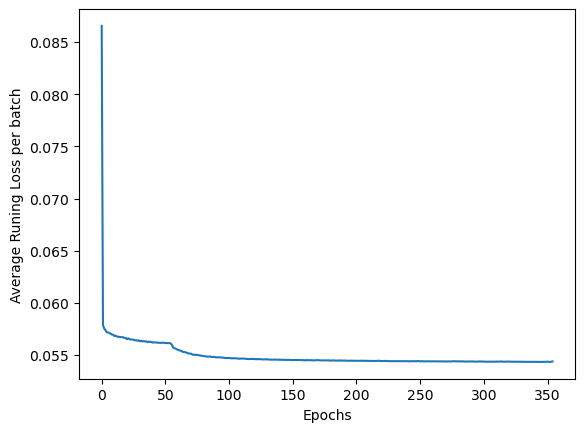

In [67]:
epoch_arr = np.arange(0, len(avg_loss_list))
loss_arr = np.array(avg_loss_list)
plt.plot(avg_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Average Runing Loss per batch")
plt.show()

In [68]:
torch.save(final_model, 'model_100206_11g_05.pt')